    signal1   signal2   signal3
0  0.111627 -0.031799 -0.063412
1 -0.436006  0.203868  0.147186
2 -0.025340  0.400516 -0.076481
3 -0.336600  1.084399  0.141319
4 -0.274862  1.234205  0.107173


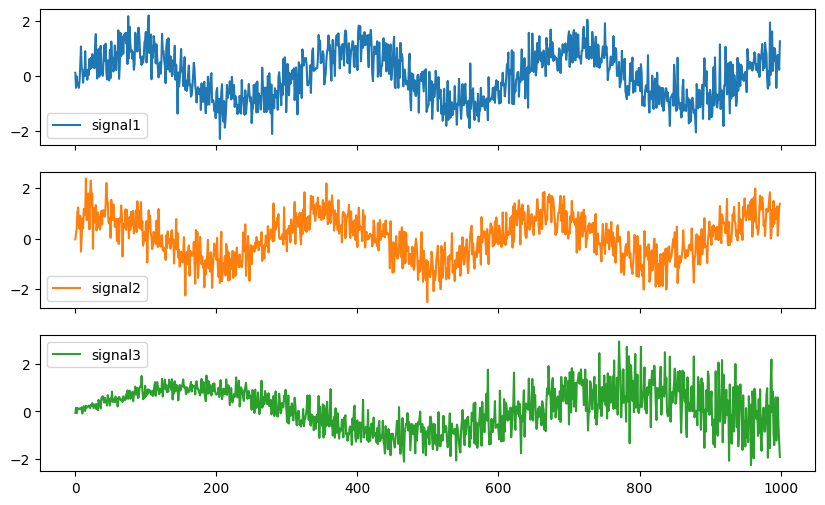

In [11]:
# Generate a Synthetic Multivariate Time Series Dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
n_samples = 1000
time = np.arange(n_samples)

# Generate correlated sine waves with evolving noise
signal1 = np.sin(0.02 * time) + 0.5 * np.random.normal(size=n_samples)
signal2 = np.sin(0.02 * time + np.pi/4) + 0.5 * np.random.normal(size=n_samples)

# Add evolving noise regime
noise_regime = np.linspace(0.1, 1.0, n_samples)
signal3 = np.sin(0.01 * time) + noise_regime * np.random.normal(size=n_samples)

# Combine into DataFrame
data = pd.DataFrame({
    "signal1": signal1,
    "signal2": signal2,
    "signal3": signal3
})

print(data.head())

# Plot
data.plot(subplots=True, figsize=(10,6))
plt.show()

In [12]:
# Define the Neural State Space Model (NSSM)
import torch
import torch.nn as nn

class TransitionModel(nn.Module):
    def __init__(self, state_dim, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )
    def forward(self, s_prev, x_t):
        inp = torch.cat([s_prev, x_t], dim=-1)
        return self.net(inp)

class ObservationModel(nn.Module):
    def __init__(self, state_dim, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, s_t, x_t, x_prev):
        inp = torch.cat([s_t, x_t, x_prev], dim=-1)
        return self.net(inp)

In [13]:
# Training Loop (Variational Inference Approximation)
import torch
import torch.nn as nn

# Redefine TransitionModel and ObservationModel here to ensure correct definitions are used
# and to be self-contained for this cell.
class TransitionModel(nn.Module):
    def __init__(self, state_dim, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, state_dim)
        )
    def forward(self, s_prev, x_t):
        inp = torch.cat([s_prev, x_t], dim=-1)
        return self.net(inp)

class ObservationModel(nn.Module):
    def __init__(self, state_dim, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            # Corrected: Input to ObservationModel's net should be state_dim (s_t) + input_dim (x_t) + input_dim (x_prev)
            nn.Linear(state_dim + input_dim + input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    def forward(self, s_t, x_t, x_prev):
        inp = torch.cat([s_t, x_t, x_prev], dim=-1)
        return self.net(inp)

class NSSM(nn.Module):
    def __init__(self, state_dim, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.transition = TransitionModel(state_dim, input_dim, hidden_dim)
        self.observation = ObservationModel(state_dim, input_dim, hidden_dim, output_dim)
        self.state_dim = state_dim

    def forward(self, x_seq):
        batch_size, seq_len, input_dim = x_seq.shape
        s_t = torch.zeros(batch_size, self.state_dim)
        outputs = []
        for t in range(seq_len):
            x_t = x_seq[:, t, :]
            x_prev = x_seq[:, t-1, :] if t > 0 else torch.zeros_like(x_t)
            s_t = self.transition(s_t, x_t)
            y_t = self.observation(s_t, x_t, x_prev)
            outputs.append(y_t.unsqueeze(1))
        return torch.cat(outputs, dim=1)

# Training
model = NSSM(state_dim=8, input_dim=3, hidden_dim=32, output_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

X = torch.tensor(data.values, dtype=torch.float32).unsqueeze(0)

for epoch in range(50):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = loss_fn(y_pred, X)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 0.7843
Epoch 10, Loss: 0.6716
Epoch 20, Loss: 0.5656
Epoch 30, Loss: 0.4590
Epoch 40, Loss: 0.3434


In [21]:
# Benchmark Against Baseline (Prophet or Transformer)
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

# Define train and test sets
train_data = data["signal1"][:-50]
test_data = data["signal1"][-50:]

# Fit the Exponential Smoothing model on the training data
baseline_model = ExponentialSmoothing(train_data, trend="add", seasonal=None).fit()

# Forecast for the test period
baseline_pred = baseline_model.forecast(len(test_data))

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(((baseline_pred - test_data)**2).mean())

print("Baseline RMSE:", rmse)

Baseline RMSE: 0.5148819158849521


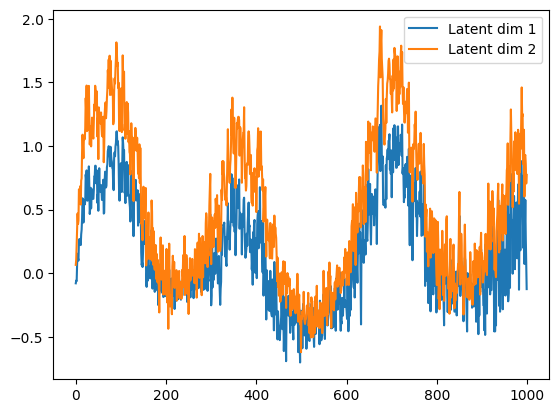

In [22]:
# Interpret Latent States
with torch.no_grad():
    latent_states = []
    s_t = torch.zeros(1, model.state_dim)
    for t in range(X.shape[1]):
        x_t = X[:, t, :]
        s_t = model.transition(s_t, x_t)
        latent_states.append(s_t.numpy())

latent_states = np.array(latent_states).squeeze()
plt.plot(latent_states[:,0], label="Latent dim 1")
plt.plot(latent_states[:,1], label="Latent dim 2")
plt.legend()
plt.show()